[View in Colaboratory](https://colab.research.google.com/github/stanimman/Pneumonia-Detection/blob/master/Keras_Clean_from_slice.ipynb)

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

<h1>Welcome to Colaboratory!</h1>
Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. See our [FAQ](https://research.google.com/colaboratory/faq.html) for more info.

## Getting Started
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Loading and saving data: Local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Using Google Cloud BigQuery](/notebooks/bigquery.ipynb)
- [Forms](/notebooks/forms.ipynb), [Charts](/notebooks/charts.ipynb), [Markdown](/notebooks/markdown_guide.ipynb), & [Widgets](/notebooks/widgets.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)
- [TensorFlow with TPU](/notebooks/tpu.ipynb)
- [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/): [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb) & [First Steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)


## Highlighted Features
### Seedbank

Looking for Colab notebooks to learn from? Check out [Seedbank](https://tools.google.com/seedbank/), a place to discover interactive machine learning examples.

### TensorFlow execution

Colaboratory allows you to execute TensorFlow code in your browser with a single click. The example below adds two matrices.

$\begin{bmatrix}
  1. & 1. & 1. \\
  1. & 1. & 1. \\
\end{bmatrix} +
\begin{bmatrix}
  1. & 2. & 3. \\
  4. & 5. & 6. \\
\end{bmatrix} =
\begin{bmatrix}
  2. & 3. & 4. \\
  5. & 6. & 7. \\
\end{bmatrix}$

In [0]:
import numpy as np

import tensorflow as tf
import time
import os

import tensorflow.keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K 

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

1.11.0
2.1.6-tf


In [4]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.60.86.242:8470


In [0]:
batch_size = 1024
num_classes = 10
epochs = 5
learning_rate = 0.001


In [6]:
!git clone https://github.com/stanimman/Pneumonia-Detection.git

Cloning into 'Pneumonia-Detection'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 55 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [16]:
!pip install -q kaggle-cli
!kg download -q -u 'stanimman' -p 'Legspinner@1' -c 'rsna-pneumonia-detection-challenge'
# !git clone https://github.com/stanimman/Pneumonia-Detection.git

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/GCP%20Credits%20Request%20Link%20-%20RSNA.txt

GCP%20Credits%20Request%20Link%20-%20RSNA.txt 100% |###| Time: 0:00:00 128.6 B/s

downloading https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/download/stage_1_detailed_class_info.csv

stage_1_detailed_class_info.csv 100% |###########

In [0]:
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images # Need to understand what is the various argument that is passed on

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
import sys
import os
import pandas as pd
from PIL import Image

In [0]:
# install dependencies not included by Colab# insta 
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [0]:
stage_1_df = pd.read_csv('Pneumonia-Detection/stage_1_train_labels.csv')

In [0]:
#import random
stage_1_df['path'] = 'stage_1_train_images/'+stage_1_df['patientId']+'.dcm'

In [0]:
Pnumenoia_Case = stage_1_df[stage_1_df.Target == 1]
Non_Pnumenoia_Case = stage_1_df[stage_1_df.Target == 0]
stage_1_train_labels_df = pd.concat([Pnumenoia_Case.iloc[range(850),:],(Non_Pnumenoia_Case.iloc[range(1500),:])])
stage_1_test_labels_df = pd.concat([Pnumenoia_Case.iloc[851:896,:],(Non_Pnumenoia_Case.iloc[1501:1551,:])])

In [13]:
print(stage_1_train_labels_df.Target.value_counts())
print(stage_1_test_labels_df.Target.value_counts())

0    1500
1     850
Name: Target, dtype: int64
0    50
1    45
Name: Target, dtype: int64


In [15]:
!ls

Pneumonia-Detection  sample_data


In [18]:
ds = pydicom.dcmread('stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm')
image = ds.pixel_array
image = np.stack((image,)*3,-1)
print(image.shape)

(1024, 1024, 3)


In [37]:
# path_tfrecords_train = os.path.join('Pneumonia-Detection', "train.tfrecords")
# path_tfrecords_train

'Pneumonia-Detection/train.tfrecords'

In [39]:
!ls Pneumonia-Detection/

Classification_Custom.ipynb
Classification.ipynb
Hello,_Colaboratory.ipynb
lesson3-rsna-pneumonia-detection-kaggle.ipynb
README.md
stage_1_detailed_class_info.csv
stage_1_train_labels.csv
TF_DataSet-recorder_Not_implemented.ipynb
White Paper


In [40]:
# path_tfrecords_test = os.path.join('Pneumonia-Detection', "test.tfrecords")
# path_tfrecords_test

'Pneumonia-Detection/test.tfrecords'

In [0]:
# def print_progress(count, total):
#     # Percentage completion.
#     pct_complete = float(count) / total

#     # Status-message.
#     # Note the \r which means the line should overwrite itself.
#     msg = "\r- Progress: {0:.1%}".format(pct_complete)

#     # Print it.
#     sys.stdout.write(msg)
#     sys.stdout.flush()

In [0]:
# def wrap_int64(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
# def wrap_bytes(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [0]:
image_paths_train = stage_1_train_labels_df.iloc[:,6].tolist()
cls_train = stage_1_train_labels_df.iloc[:,5].tolist()
cls_train = tf.keras.utils.to_categorical(cls_train, 2)

In [0]:
image_paths_test = stage_1_test_labels_df.iloc[:,6].tolist()
cls_test = stage_1_test_labels_df.iloc[:,5].tolist()
cls_test = tf.keras.utils.to_categorical(cls_test, 2)

In [94]:
cls_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
def _parse_function_check(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array
    img = np.stack((img,)*3,-1)
    image = tf.cast(img, tf.float32)
    return image

In [89]:
_parse_function_check('stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm')

<tf.Tensor 'Cast:0' shape=(1024, 1024, 3) dtype=float32>

In [0]:
# step 3: parse every image in the dataset using `map`
def _parse_function(path, label):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array
    img = np.stack((img,)*3,-1)
    image = tf.cast(img, tf.float32)
    return image, label
    
def train_input_fn_slice(filenames,label_value,batch_size=1024):
    # convert the inputs to a Dataset.
    filenames = tf.constant(filenames)
    labels = tf.constant(label_value)

    # step 2: create a dataset returning slices of `filenames`
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    dataset = dataset.map(_parse_function)

    # shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size, drop_remainder=True)

    # return the dataset.
    return dataset

In [23]:
input_shape = image.shape
input_shape

(1024, 1024, 3)

In [0]:
Inp = tf.keras.Input(
    name='input', shape=input_shape, batch_size=batch_size, dtype=tf.float32)

x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_03')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(64, activation='relu',name = 'Dense_01')(x)
x = Dropout(0.5,name = 'Dropout_02')(x)

output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)

In [0]:
model = tf.keras.Model(inputs=[Inp], outputs=[output])

In [0]:
# use a tf optimizer rather than a Keras one for now
opt = tf.train.AdamOptimizer(learning_rate)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['acc'])

In [27]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.60.86.242:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5609960183881329591)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5463546567359376403)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 16562352525920666708)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14377218394816686110)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9680737408913642232)
INFO:tensorflow:*** Available Device: _Device

In [28]:
tpu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (1024, 1024, 1024, 3)     0         
_________________________________________________________________
Conv_01 (Conv2D)             (1024, 1022, 1022, 32)    896       
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (1024, 511, 511, 32)      0         
_________________________________________________________________
Conv_02 (Conv2D)             (1024, 509, 509, 64)      18496     
_________________________________________________________________
MaxPool_02 (MaxPooling2D)    (1024, 254, 254, 64)      0         
_________________________________________________________________
Conv_03 (Conv2D)             (1024, 252, 252, 64)      36928     
_________________________________________________________________
Flatten_01 (Flatten)         (1024, 4064256)           0         
__________

In [32]:
tpu_model.fit(
  train_input_fn_slice(image_paths_train,cls_train),
  steps_per_epoch = 60,
  epochs=10,
)

AttributeError: ignored

In [0]:
def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    
    print("Converting: " + out_path)
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)

            # Load the image-file using matplotlib's imread function.
            #img = imread(path)
            ds = pydicom.dcmread(path)
            img = ds.pixel_array
            img = np.stack((img,)*3,-1)
            #print(image.shape)
            
            # Convert the image to raw bytes.
            img_bytes = img.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

In [57]:
convert(image_paths=image_paths_train,
        labels=cls_train,
        out_path=path_tfrecords_train)

Converting: Pneumonia-Detection/train.tfrecords
- Progress: 100.0%

In [58]:
convert(image_paths=image_paths_test,
        labels=cls_test,
        out_path=path_tfrecords_test)

Converting: Pneumonia-Detection/test.tfrecords
- Progress: 100.0%

In [0]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)

    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [0]:
def input_fn(filenames, train, batch_size=32, buffer_size=2048):
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)

    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    dataset = dataset.batch(batch_size,drop_remainder=True)

    # Create an iterator for the dataset and the above modifications.
    #iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    #images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    #x = {'image': images_batch}
    #y = labels_batch

    return dataset

In [0]:
def train_input_fn_new():
    return input_fn(filenames=path_tfrecords_train, train=True)

In [0]:
def test_input_fn_new():
    return input_fn(filenames=path_tfrecords_test, train=False)

In [61]:
batch_size =128
input_shape = image.shape

(1024, 1024, 3)

In [0]:
Inp = tf.keras.Input(
    name='input', shape=input_shape, batch_size=batch_size, dtype=tf.float32)

x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_02')(x)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_03')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(64, activation='relu',name = 'Dense_01')(x)
x = Dropout(0.5,name = 'Dropout_02')(x)

output = Dense(2, activation='softmax',name = 'Dense_02')(x)

In [0]:
model = tf.keras.Model(inputs=[Inp], outputs=[output])

In [0]:
# use a tf optimizer rather than a Keras one for now
opt = tf.train.AdamOptimizer(learning_rate)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['acc'])

In [83]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.112.238.210:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4000352352448438693)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1466885653608979818)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 2966684477261637289)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15192238822743238694)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3246125469554995092)
INFO:tensorflow:*** Available Device: _Devic

ValueError: ignored

In [66]:
tpu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (1024, 28, 28, 1)         0         
_________________________________________________________________
Conv_01 (Conv2D)             (1024, 26, 26, 32)        320       
_________________________________________________________________
MaxPool_01 (MaxPooling2D)    (1024, 13, 13, 32)        0         
_________________________________________________________________
Conv_02 (Conv2D)             (1024, 11, 11, 64)        18496     
_________________________________________________________________
MaxPool_02 (MaxPooling2D)    (1024, 5, 5, 64)          0         
_________________________________________________________________
Conv_03 (Conv2D)             (1024, 3, 3, 64)          36928     
_________________________________________________________________
Flatten_01 (Flatten)         (1024, 576)               0         
__________

In [75]:
tpu_model.fit(
  train_input_fn_new,
  steps_per_epoch = 60,
  epochs=10,
)

ValueError: ignored

In [0]:
tpu_model.fit(
  train_input_fn,
  steps_per_epoch = 60,
  epochs=10,
)

### GitHub

You can save a copy of your Colab notebook to Github by using File > Save a copy to GitHub…

You can load any .ipynb on GitHub by just adding the path to colab.research.google.com/github/ . For example, [colab.research.google.com/github/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb) will load [this .ipynb](https://github.com/tensorflow/models/blob/master/samples/core/get_started/_index.ipynb) on GitHub.



### Visualization

Colaboratory includes widely used libraries like [matplotlib](https://matplotlib.org/), simplifying visualization.

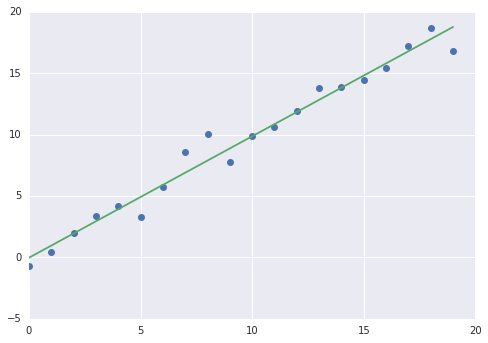

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(20)
y = [x_i + np.random.randn(1) for x_i in x]
a, b = np.polyfit(x, y, 1)
_ = plt.plot(x, y, 'o', np.arange(20), a*np.arange(20)+b, '-')

Want to use a new library?  `pip install` it at the top of the notebook. Then that library can be used anywhere else in the notebook. For recipes to import commonly used libraries, refer to the [importing libraries example notebook](/notebooks/snippets/importing_libraries.ipynb).

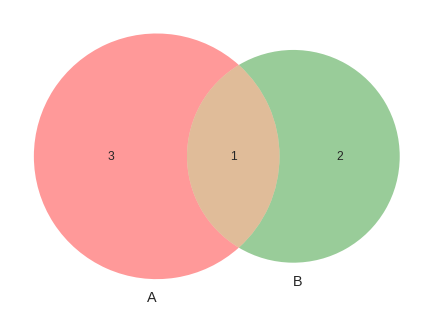

In [0]:
!pip install -q matplotlib-venn

from matplotlib_venn import venn2
_ = venn2(subsets = (3, 2, 1))

### Forms

Forms can be used to parameterize code. See the [forms example notebook](/notebooks/forms.ipynb) for more details.

In [0]:
#@title Examples

text = 'value' #@param 
date_input = '2018-03-22' #@param {type:"date"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]


### Local runtime support

Colab  supports connecting to a Jupyter runtime on your local machine. For more information, see our [documentation](https://research.google.com/colaboratory/local-runtimes.html).